In [184]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm
# from sklearn.model_selection import train_test_split

In [185]:
device = (
    (torch.cuda.is_available() and "cuda")
    or (torch.backends.mps.is_available() and "mps")
    or "cpu"
)
torch.device(device)

device(type='mps')

In [186]:
# MANUAL SEED per partire sempre nelle stesse condizioni

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

match device:
    case "cuda":
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
    case "mps":
        torch.mps.manual_seed(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [187]:
df = pd.read_csv("input/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


DESCRIZIONE COLONNE del dataset -> https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

| Colonna        | Descrizione                                                        |
| -------------- | ------------------------------------------------------------------ |
| Age            | Età del paziente in anni                                           |
| Sex            | Sesso biologico                                                    |
| ChestPainType  | Tipo di dolore toracico (ASY, ATA, NAP, TA)                        |
| RestingBP      | Pressione sanguigna a riposo (in mm Hg)                            |
| Cholesterol    | Livello di colesterolo                                             |
| FastingBS      | Glicemia a digiuno (>120 mg/dl indica possibile diabete)           |
| RestingECG     | Risultati ECG a riposo (Normal, ST, LVH)                           |
| MaxHR          | Frequenza cardiaca massima raggiunta durante il test               |
| ExerciseAngina | Presenza di angina indotta dall'esercizio (booleano)               |
| Oldpeak        | Depressione ST indotta dall'esercizio rispetto al riposo           |
| ST_Slope       | Pendenza del segmento ST all'apice dell'esercizio (Up, Flat, Down) |
| HeartDisease   | Diagnosi di malattia cardiaca (sì/no)                              |

**Note:**

- I tipi di dolore toracico (ChestPainType) possono indicare diversi tipi di angina o condizioni non cardiache.
- I risultati dell'ECG (RestingECG) aiutano ad identificare anomalie cardiache.
- La glicemia a digiuno (FastingBS) è un fattore di rischio per le malattie cardia


In [188]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [189]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [190]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype("int")

string_cols = df.select_dtypes(include="object").columns
df[string_cols] = df[string_cols].astype("string")
df.dtypes

Age                        int64
Sex               string[python]
ChestPainType     string[python]
RestingBP                  int64
Cholesterol                int64
FastingBS                  int64
RestingECG        string[python]
MaxHR                      int64
ExerciseAngina    string[python]
Oldpeak                  float64
ST_Slope          string[python]
HeartDisease               int64
dtype: object

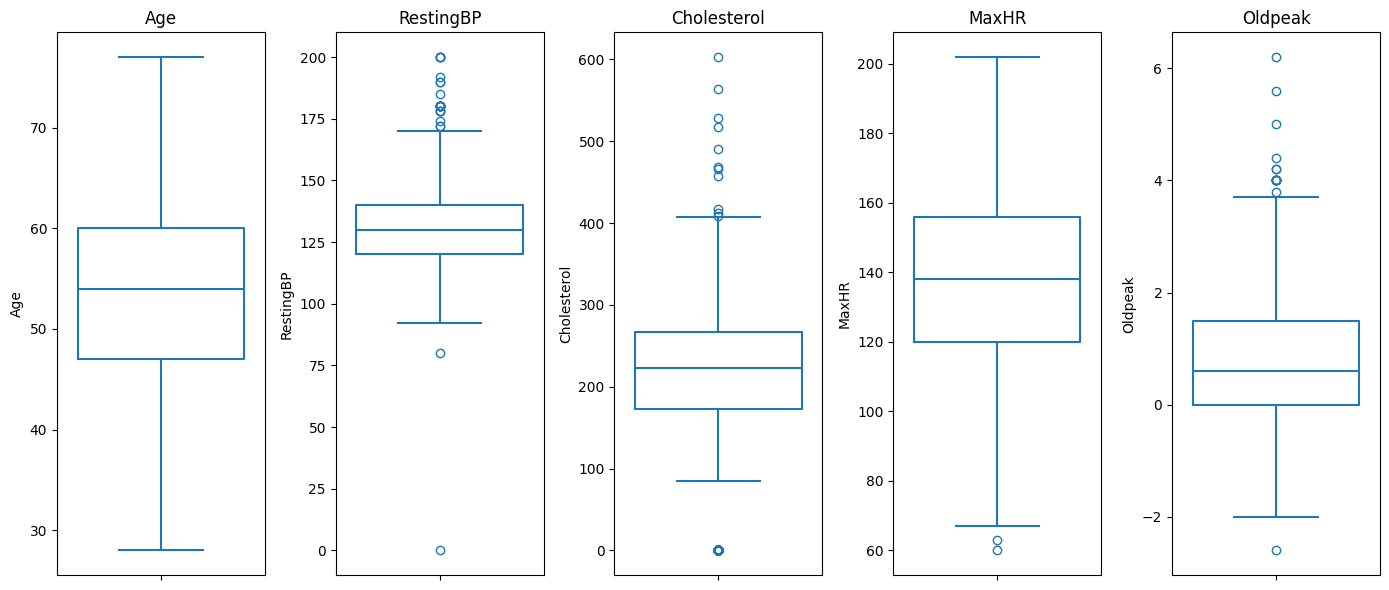

In [191]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
numerical_cols = numerical_cols.drop(
    ["HeartDisease", "FastingBS"]
)  # rimuovo la colonna target e la colonna FastingBS

fig, axs = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(14, 6))

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axs[i], fill=False)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [192]:
# Rimozione outliers
resting_bp_outliers = df[df["RestingBP"] < 20]  # è morto? Lo rimuovo?
df.drop(resting_bp_outliers.index, inplace=True)

df[df["Cholesterol"] == 0].value_counts().sum()  # colesterolo tropo basso
df.drop(df[df["Cholesterol"] == 0].index, inplace=True)
df.value_counts().sum()

746

In [193]:
# One-hot encoding
df = pd.get_dummies(df, columns=list(string_cols), drop_first=True, dtype=int)
# Dove:
# - drop_first=True rimuove la prima colonna (prima categoria della colonna) dummy per evitare la multi-collinearità
df.head()


# poi riposizionamo la colonna target come ultima
target_col = df["HeartDisease"]
df.drop("HeartDisease", axis=1, inplace=True)
df = pd.concat([df, target_col], axis=1)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,1,1,0,0,1,0,0,0,1,0
1,49,160,180,0,156,1.0,0,0,1,0,1,0,0,1,0,1
2,37,130,283,0,98,0.0,1,1,0,0,0,1,0,0,1,0
3,48,138,214,0,108,1.5,0,0,0,0,1,0,1,1,0,1
4,54,150,195,0,122,0.0,1,0,1,0,1,0,0,0,1,0


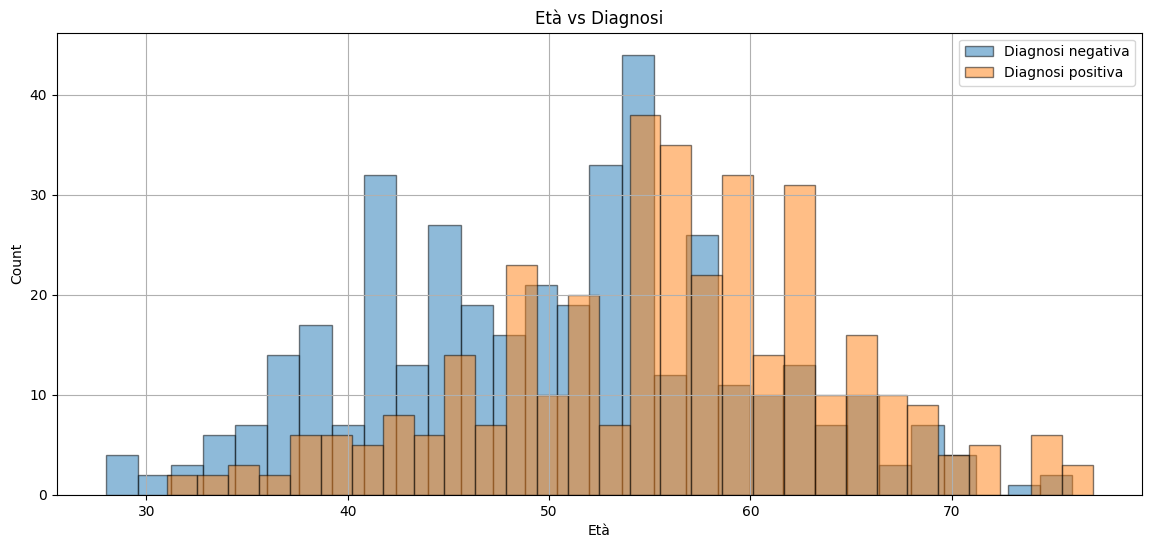

In [194]:
# Mostriamo relazione tra età e diagnosi
fig, ax = plt.subplots(figsize=(14, 6))


df[df["HeartDisease"] == 0]["Age"].hist(
    ax=ax, bins=30, edgecolor="black", alpha=0.5, label="Diagnosi negativa"
)
df[df["HeartDisease"] == 1]["Age"].hist(
    ax=ax, bins=30, edgecolor="black", alpha=0.5, label="Diagnosi positiva"
)


ax.set_title("Età vs Diagnosi")
ax.set_xlabel("Età")
ax.set_ylabel("Count")


ax.legend()


plt.show()

In [195]:
# funzioni calcolo dev standard e correlazione (per puro scopo educativo)


def calc_std(values):
    n = len(values)
    m = sum(values) / n
    return np.sqrt(
        sum((c - m) ** 2 for c in values) / (n - 1)
    )  # n-1 perchè si tratta di un campione e non dell'intera popolazione


def calc_corr(v1, v2):
    n = len(v1)
    if n != len(v2):
        raise ValueError("Arrays must have the same length")
    m1 = sum(v1) / n
    m2 = sum(v2) / n
    s1 = calc_std(v1)
    s2 = calc_std(v2)
    return sum(((c1 - m1) * (c2 - m2) for (c1, c2) in zip(v1, v2))) / (
        (n - 1) * s1 * s2
    )

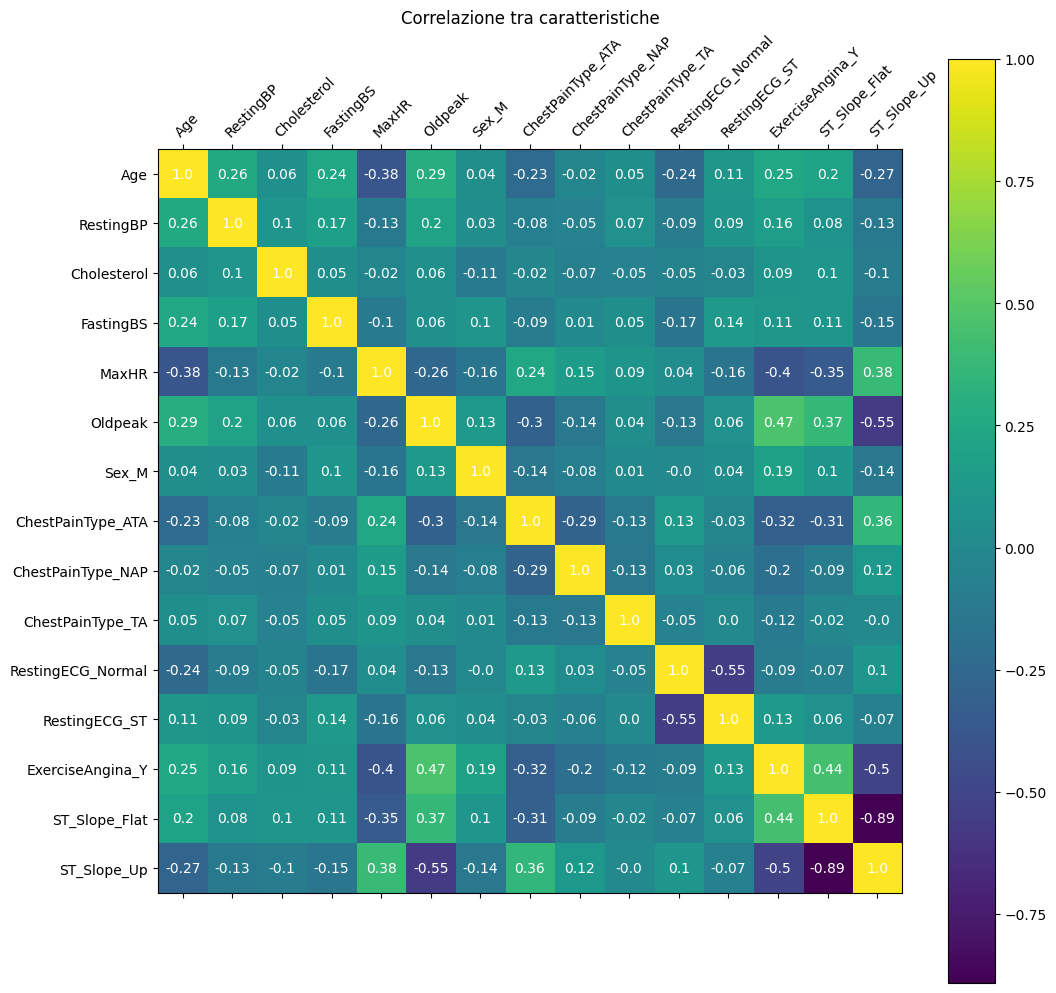

In [196]:
# Matrice di correlazione


cols = df.keys()[:-1]  # remove the target column

# cols = ["Age", "Sex", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

corr_mat = []
for row_key in cols:
    row = []
    for col_key in cols:
        # corr = calc_corr(df[row_key], df[col_key])
        # altamente inefficiente con il mio metodo, numpy invece usa c bindings e penso parallelizzi
        corr = df[row_key].corr(df[col_key])
        row.append(corr)
    corr_mat.append(row)


fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(corr_mat)
fig.colorbar(cax, ax=ax)


ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))

ax.set_xticklabels(cols)
ax.set_yticklabels(cols)

plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

for i in range(len(corr_mat)):
    for j in range(len(corr_mat[i])):
        ax.text(j, i, round(corr_mat[i][j], 2), ha="center", va="center", color="w")

ax.set_title("Correlazione tra caratteristiche")

plt.show()

In [197]:
# Gestione multicollinearità
clean_df = df.copy()
clean_df.drop("ST_Slope_Up", axis=1, inplace=True)
# clean_df.drop("RestingECG_ST", axis=1, inplace=True)


# Preparazione input e target modello
scaler = StandardScaler()
input_data = torch.from_numpy(
    scaler.fit_transform(clean_df.drop("HeartDisease", axis=1).to_numpy())
).float()
# input_data = torch.from_numpy(clean_df.drop("HeartDisease", axis=1).to_numpy()).float()
target_data = torch.from_numpy(clean_df["HeartDisease"].to_numpy()).float().unsqueeze(1)

dataset = TensorDataset(input_data, target_data)
train_data_len = int(len(dataset) * 0.8)
test_data_len = int(len(dataset) - train_data_len)
train_dataset, test_dataset = random_split(dataset, [train_data_len, test_data_len])

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [198]:
class LogisticRegressionNet(nn.Module):
    """Modello di rete neurale per la regressione logistica."""

    def __init__(self, input_size=input_data.shape[1]):
        super(LogisticRegressionNet, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


class MLPNet(nn.Module):
    """Modello di rete neurale multistrato (MLP)"""

    def __init__(self, input_size=input_data.shape[1], hidden_size=64):
        super(MLPNet, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu_stack(x)
        x = self.sigmoid(x)
        return x


# Hyper-params
lr = 1e-3
epochs = 100


# net = MLPNet()
# net.to(device)

loss_fn = nn.BCELoss()  # Binary Cross Entropy
# Dove:
# - BCELoss: usato per classificazione binaria e NON include layer sigmoid
# - BCEWithLogitsLoss: usato per classificazione binaria e include layer sigmoid
# nel nostro caso, abbiamo incluso il layer sigmoid nel modello, quindi usiamo BCELoss

# Optimizer
# optmzr = optim.Adam(net.parameters(), lr=lr)
# Dove:
# - SGD: utilizza una sola riga del batch per calcolare il gradiente e aggiornare i pesi
# - Adam: genera una desc. statistica (e.g. media, std) dei gradienti calcolati per più righe del batch e ottimizza il learning rate di conseguenza

In [199]:
from typing import List, Tuple


def train_loop(
    model: nn.Module,
    dataloader,
    loss_fn,
    optimizer: optim.Optimizer,
    step=10,
    is_print_step=False,
):
    model.train()
    size = len(dataloader.dataset)

    for batch_idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if is_print_step and (
            (batch_idx == 0)
            or ((batch_idx + 1) % step == 0)
            or ((batch_idx + 1) == len(dataloader))
        ):
            loss, current = loss.item(), (batch_idx * batch_size) + len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test_loop(
    model: nn.Module, dataloader, loss_fn, treshold=0.75, is_print_report=False
):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred >= treshold).eq(y).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    if is_print_report:
        print(
            f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        )

    return test_loss, accuracy


def train(
    model: nn.Module,
    optimizer,
    loss_fn: nn.Module = loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs: int = 100,
    # treshold: float = 0.75,
) -> Tuple[List[float], List[float]]:
    """funzione per addestrare il modello su più epoche"""
    loss_values = []
    accuracy_values = []
    for epoch_idx in tqdm(range(epochs)):
        # print(f"Epoca {epoch_idx+1}\n---------------------------------")
        train_loop(model, train_dataloader, loss_fn, optimizer)
        loss, accuracy = test_loop(
            model,
            test_dataloader,
            loss_fn,
            # treshold,
        )
        accuracy_values.append(accuracy)
        loss_values.append(loss)

    return loss_values, accuracy_values

In [200]:
def train_model(model_class, optimizer_class, description):
    print(f"Modello {description}\n")
    # start_time = time.time()
    model = model_class().to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)
    loss_values, acc_values = train(model, optimizer)
    # end_time = time.time()
    # delta_time = end_time - start_time
    # print(f"\nCompletato in {delta_time:.2f} secondi\n")
    return model, (loss_values, acc_values)


model_configs = [
    {
        "description": "Regressione Logistica Binaria",
        "model_class": LogisticRegressionNet,
        "optimizer_class": optim.Adam,
    },
    {
        "description": "Multi Layer Perceptron",
        "model_class": MLPNet,
        "optimizer_class": optim.Adam,
    },
]


for idx, config in enumerate(model_configs):
    model, (loss_values, acc_values) = train_model(**config)
    config["model"] = model
    description = config.get("description", idx)
    print(f"\nAccuratezza media del {np.mean(acc_values):.2f}%\n")
    print("_" * 100, "\n\n")

Modello Regressione Logistica Binaria



100%|██████████| 100/100 [00:02<00:00, 45.70it/s]



Accuratezza media del 67.65%

____________________________________________________________________________________________________ 


Modello Multi Layer Perceptron



100%|██████████| 100/100 [00:03<00:00, 31.53it/s]


Accuratezza media del 77.10%

____________________________________________________________________________________________________ 




Modello Regressione Logistica Binaria
Threshold ottimale: 0.40
TP: 81.33%
FP: 12.00%

Modello Multi Layer Perceptron
Threshold ottimale: 0.50
TP: 82.67%
FP: 5.33%



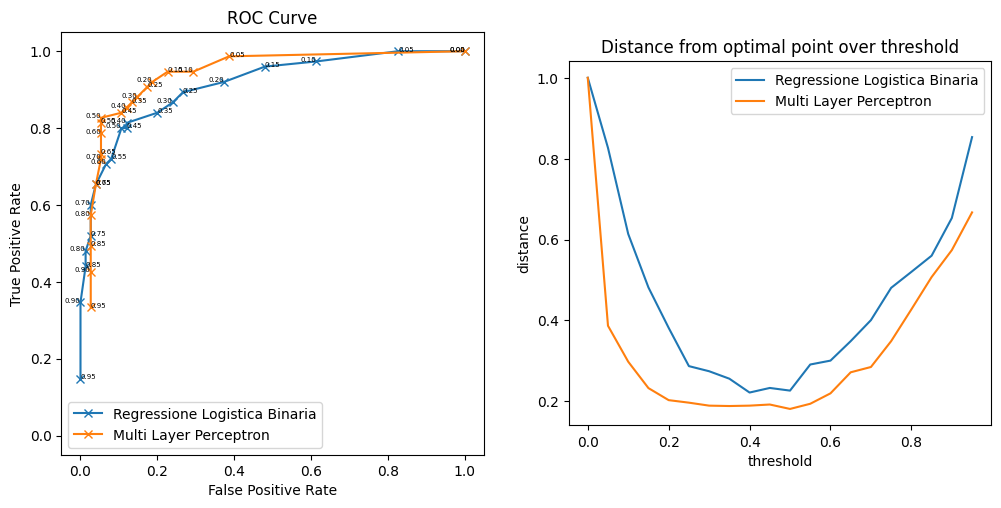

In [201]:
# ROC curve
# Trovare il treshold ottimale

test_X, test_y = zip(*test_dataset)  # zip si comporta come l'operatore trasposizione
test_X = torch.stack(test_X)
test_y = torch.stack(test_y)


threshold_values = np.arange(0, 1, 0.05, dtype=np.float32)

fp_optimal, tp_optimal = 0, 1  # punto ottimale curva ROC


# calcola le percentuali di true positve e false positive

for idx, config in enumerate(model_configs):
    model = config["model"].to(device)

    X = test_X.to(device)
    with torch.no_grad():
        model.eval()
        pred = model(X)
    pred = pred.cpu().numpy()

    print(f"Modello {config['description']}")

    tpfp_values = []
    min_dist = np.infty
    dist_values = []
    optimal_threshold = threshold_values[0]
    optimal_threshold_idx = 0

    for idx, threshold in enumerate(threshold_values):
        # pred_y è pred sogliata con la soglia corrente
        pred_y = (pred > threshold).astype(np.int8)
        y = test_y.numpy().astype(np.int8)
        tp = np.sum(pred_y & y) / np.sum(y)
        fp = np.sum(pred_y & (1 - y)) / np.sum(1 - y)
        point_dist = np.sqrt((tp_optimal - tp) ** 2 + (fp_optimal - fp) ** 2)
        dist_values.append(point_dist)
        if point_dist < min_dist:
            min_dist = point_dist
            optimal_threshold = threshold
            optimal_threshold_idx = idx

        tpfp_values.append((tp, fp))

        # print(f"{t:.1f}, {100*tp:.2f}%, {100*fp:.2f}%")

    tp, fp = tpfp_values[optimal_threshold_idx]
    config["tpfp_values"] = tpfp_values
    config["optimal_threshold"] = optimal_threshold
    config["dist_values"] = dist_values
    print(f"Threshold ottimale: {optimal_threshold:.2f}")
    print(f"TP: {100*tp:.2f}%")
    print(f"FP: {100*fp:.2f}%\n")


# curva ROC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# ax.plot([0, 1], [0, 1], linestyle="--", color="r", label="")

for config in model_configs:
    tp, fp = zip(*config["tpfp_values"])
    dist_values = config["dist_values"]
    ax1.plot(fp, tp, label=config["description"], marker="x")
    ax2.plot(threshold_values, dist_values, label=config["description"])

    # mostra le soglie con cui sono stati ottenuti i punti nel plot
    for idx, (fp_i, tp_i) in enumerate(zip(fp, tp)):
        ax1.text(
            fp_i,
            tp_i,
            f"{threshold_values[idx]:.2f}",
            ha=("right" if idx % 2 == 0 else "left"),
            fontsize=5,
            color="#000000",
        )

ax1.set_aspect("equal")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curve")
ax1.legend()
ax1.set_xlim(0 - 0.05, 1 + 0.05)
ax1.set_ylim(0 - 0.05, 1 + 0.05)

ax2.set_title("Distance from optimal point over threshold")
ax2.set_aspect("equal")
ax2.set_xlabel("threshold")
ax2.set_ylabel("distance")
ax2.legend()

# curva thresholds


plt.show()